### Calculate vertical velocity from EM-APEX float data 

Following methods from Phillips & Bindoff (2014)

In [18]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cmocean
import datetime
import math
import gsw
import pandas as pd
import stat
from timeit import default_timer as timer
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams['font.size'] = '14'

In [2]:
import imp
import src.importData as imports
import src.calc as calc
import src.concat as ct
import src.settings as settings
import src.stats as stats
import src.plots as plots
import src.velocities as vel
import src.interpolation as interp

In [3]:
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter1_manuscript')

In [4]:
# Import float data
floatids = [8489, 8492, 8493]
ema = imports.importFloatData(floatids)

# import altimetry dataset 
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

In [5]:
abs_vels = {}
rot_vels = {}
ctd_time = {}

floatdir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
                       
for floatid in floatids:
    #absolute velocities
    file = os.path.join(floatdir, 'absolute_velocity', 'by_profile', 'abs_vel_%s_extra_qc.nc' %floatid)
    abs_vels[floatid] = xr.open_dataset(file)
    
    #rotated velocities
    file = os.path.join(floatdir, 'rotated_velocity', 'by_profile', 'rot_vel_%s.nc' %floatid)
    rot_vels[floatid] = xr.open_dataset(file)
    
    # time recorded from float ctd
    file = os.path.join(floatdir, 'extra_vars', 'macquarie_ema-%s_qc.nc' %floatid)
    ctd_time[floatid] = xr.open_dataset(file).ctd_t


In [6]:
imp.reload(imports)
ds = imports.sub_inertial_ds(ema, floatids, floatdir, xdim = 'profile')
ds_dist = imports.sub_inertial_ds(ema, floatids, floatdir, xdim = 'distance', rot_vels = rot_vels)

### Calculate and save datasets to netcdf

In [7]:
# x_dim = 'by_distance' #'by_profile'
# datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats', 'vertical_velocity', x_dim)

# floatid = 8489

# u_rot = ds_dist[floatid].u_rot
# v_rot = ds_dist[floatid].v_rot

# imp.reload(vel)
# deriv_ds = vel.vert_vel_deriv(ds_dist[floatid], floatid, u_rot, v_rot, smooth_vels = True, 
#                                               save_file = True, filename = 'deriv_ds_extra_qc')

In [8]:
# imp.reload(vel)
# vert_vel = vel.calc_w(ds_dist[floatid], floatid, u_rot, v_rot, deriv_ds, 
#                       smooth_vels = True, by_dist = True, save_file = True, filename = 'vert_vel_extra_qc')

### Import datasets

In [9]:
CT, SA = {}, {}
deriv_ds = {}
vert_vel = {}

x_dim = 'by_distance' #'by_profile'
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats', 'vertical_velocity', x_dim)

for floatid in floatids:
    # T and S (no inertial)
    CT[floatid], SA[floatid] = ds_dist[floatid].CT, ds_dist[floatid].SA

    deriv_ds[floatid] = imports.importNetCDF(datadir, 'deriv_ds_extra_qc_%s.nc' %floatid)
    vert_vel[floatid] = imports.importNetCDF(datadir, 'vert_vel_extra_qc_%s.nc' %floatid)

### Smoothed velocities - example profiles
Using Savitzky-Golay filter and a vertical roolling window of 150 dbar

In [11]:
# vertically smoothed velocities
floatid = 8489
u_rot = rot_vels[floatid].u_rot
v_rot = rot_vels[floatid].v_rot

u_smooth = vel.smooth_prof_by_prof(u_rot)
v_smooth = vel.smooth_prof_by_prof(v_rot)

(-0.2, 0.3)

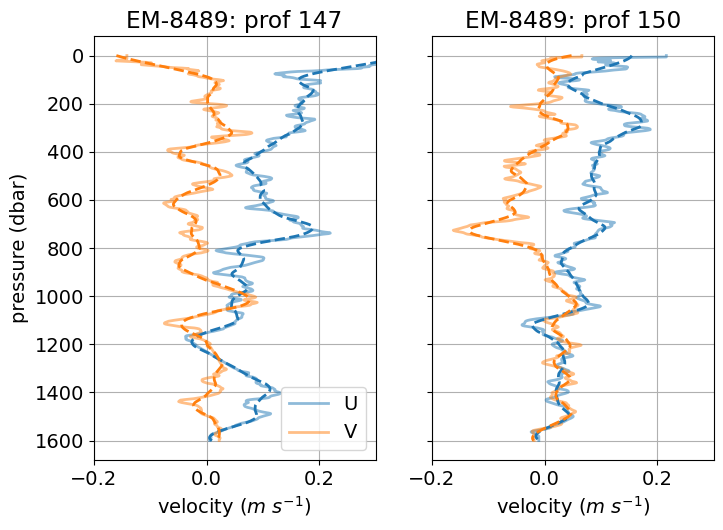

In [12]:
prof = 146

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (8,5.5))
u_rot[prof].plot(ax= ax1, y = 'pressure', linewidth = 2, alpha = 0.5)
v_rot[prof].plot(ax = ax1, y = 'pressure', linewidth = 2, alpha = 0.5)
ax1.legend(['U', 'V'])
u_smooth[prof].plot(ax = ax1, y = 'pressure', linestyle = '--', c = 'tab:blue', linewidth = 2, zorder = 3)
v_smooth[prof].plot(ax = ax1, y = 'pressure', linestyle = '--', c = 'tab:orange', linewidth = 2, zorder = 3)
ax1.set_xlabel('velocity ($m$ $s^{-1}$)')
ax1.grid()
ax1.set_ylabel('pressure (dbar)')
ax1.invert_yaxis()
ax1.set_title(f'EM-{floatid}: prof {prof+1}')
ax1.set_xlim(-0.2, 0.3)

prof = 149
u_rot[prof].plot(ax= ax2, y = 'pressure', linewidth = 2, alpha = 0.5)
v_rot[prof].plot(ax = ax2, y = 'pressure', linewidth = 2, alpha = 0.5)
u_smooth[prof].plot(ax = ax2, y = 'pressure', linestyle = '--', c = 'tab:blue', linewidth = 2, zorder = 3)
v_smooth[prof].plot(ax = ax2, y = 'pressure', linestyle = '--', c = 'tab:orange', linewidth = 2, zorder = 3)
ax2.set_xlabel('velocity ($m$ $s^{-1}$)')
ax2.grid()
ax2.set_ylabel('')
ax2.set_title(f'EM-{floatid}: prof {prof+1}')
ax2.set_xlim(-0.2, 0.3)

# settings.save_figure(fig, my_path, 'vels_vertical_smoothing.png', dpi = 300, pad = 0.2)

### Concatenated floats

In [13]:
imp.reload(interp)
T_even_concat, T_smooth_concat, T_smooth, T_even_dist = interp.grid_and_smooth(CT, floatids)
S_even_concat, S_smooth_concat, S_smooth, S_even_dist = interp.grid_and_smooth(SA, floatids)

pdens = calc.potentialDensity(S_even_concat.pressure, S_even_concat, T_even_concat)
levels = np.arange(26.8,np.nanmax(pdens),0.1)
# mld_on_p = calc.MLD(pdens, criteria = 0.05, pref = 10)

In [14]:
# mixed layer depth 
mld = {}
for floatid in floatids:
    mld[floatid] = calc.MLD_float(ds_dist[floatid], floatid, plot = False)

mld_on_p, end_dist, d_rs = ct.concatenated_flts(mld, floatids, new_dim = True)

In [15]:
w = {}
w_prof = {}
for floatid in floatids:
    w_total = vert_vel[floatid].w_total.copy()
    mask = (abs(w_total) >= 0.1)
    w_total.data[mask] = np.nan
    w[floatid] = w_total
    
    w_prof[floatid] = xr.DataArray(w_total.data, dims = ['profile', 'pressure'], coords = ds[floatid].u_rot.coords)
    

# evenely grid in distance and smooth 
w_even_concat, w_smooth_concat, w_smooth, w_even_dist = interp.grid_and_smooth(w, floatids)
ticks, values, flt_dist_loc = plots.concatTickValues(w)

Text(0.8, 1.02, 'EM-8493')

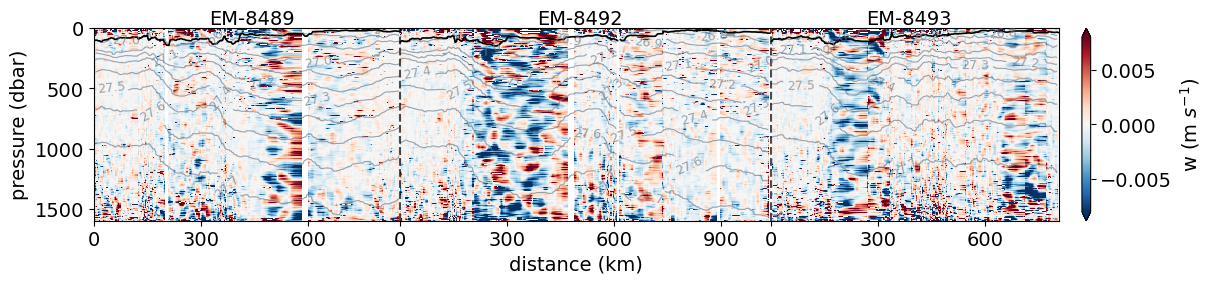

In [16]:
fig, ax = plt.subplots(figsize = (15,2.5))
im1 = w_even_concat.plot(x = 'distance', cmap = 'RdBu_r', vmin = -0.008, vmax = 0.008,
                                            cbar_kwargs={"label": "w (m $s^{-1}$)", 'pad': 0.02, 'extend':'both'})

for i in range(0,len(flt_dist_loc)):
    ax.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)
    
ax.set_xticks(ticks)
ax.set_xticklabels(values)

ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.7)
plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel('pressure (dbar)')

ax.text(0.12, 1.02, 'EM-8489', transform = ax.transAxes)
ax.text(0.46, 1.02, 'EM-8492', transform = ax.transAxes)
ax.text(0.8, 1.02, 'EM-8493', transform = ax.transAxes)

In [ ]:
# settings.save_figure(fig, my_path, 'w_section.png', dpi = 600, pad = 0.2)

In [17]:
pdens_even_d = {}
mld_even_d = {}

pdens_prof = {}
mld_prof = {}
for floatid in floatids:
    pdens_even_d[floatid] = calc.potentialDensity(T_even_dist[floatid].pressure, S_even_dist[floatid], T_even_dist[floatid])
    mld_even_d[floatid] = calc.MLD(pdens_even_d[floatid], criteria = 0.05, pref = 10)
    
    pdens_prof[floatid] = calc.potentialDensity(ds[floatid].pressure, ds[floatid].SA, ds[floatid].CT)
    mld_prof[floatid] = calc.MLD(pdens_prof[floatid], criteria = 0.05, pref = 10)

In [19]:
levels = np.arange(26.9,27.9,0.2)

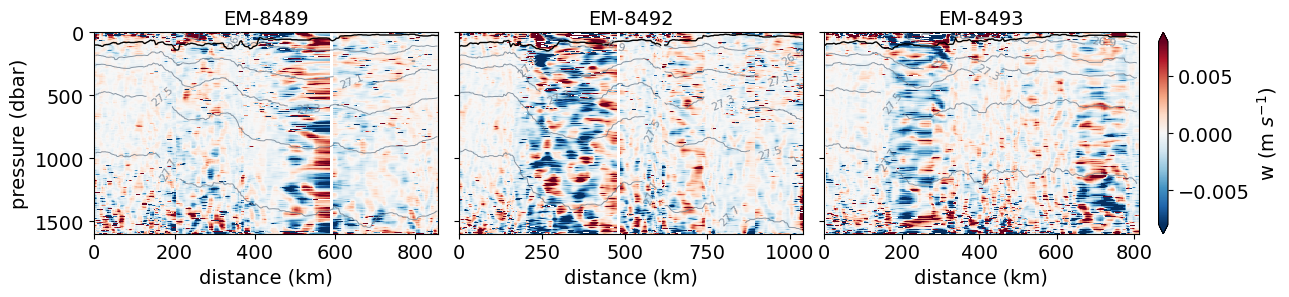

In [20]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3.2))
axs = ax.flatten()

i = 0
for floatid in floatids:
    
    im = w_smooth[floatid].plot(ax = axs[i], x = 'distance', cmap = 'RdBu_r', vmin = -0.008, vmax = 0.008, add_colorbar = False)
    
    mld_even_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    CS = pdens_even_d[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'slategrey', linewidths = 0.7, 
                                            levels = levels, alpha = 0.8)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'w (m $s^{-1}$)', extend = 'both')

In [15]:
# settings.save_figure(fig, my_path, 'vert_vel.png', dpi = 600, pad = 0.2)

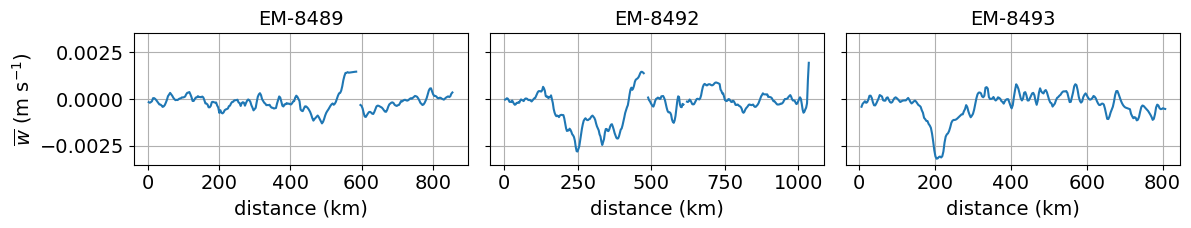

In [21]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 2.5))
axs = ax.flatten()

i = 0
for floatid in floatids:
    w_mean = calc.mean_below_ml(w_smooth[floatid], mld_even_d[floatid], zmax = 1500, zdim = 'pressure')

    axs[i].plot(w_smooth[floatid].distance, w_mean)
    axs[i].grid()
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    
    i+=1

axs[0].set_ylim(-0.0035, 0.0035)
axs[0].set_ylabel(u'$\overline{w}$ (m s$^{-1}$)')

plt.tight_layout(w_pad = 0.7)

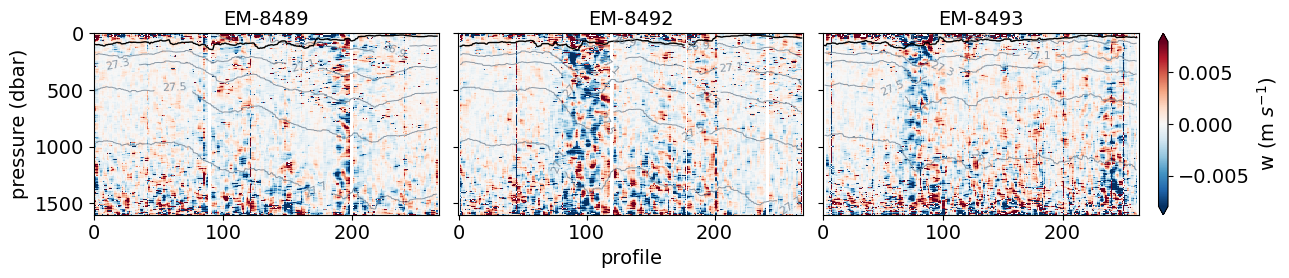

In [22]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (12, 3))
axs = ax.flatten()

i = 0
for floatid in floatids:
    
    im = w_prof[floatid].plot(ax = axs[i], x = 'profile', cmap = 'RdBu_r', vmin = -0.008, vmax = 0.008, add_colorbar = False)
    
    mld_prof[floatid].plot(ax = axs[i], c = 'k', linewidth = 1)
    
    CS = pdens_prof[floatid].plot.contour(ax = axs[i], x = 'profile', colors = 'slategrey', linewidths = 0.7, 
                                            levels = levels, alpha = 0.8)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('profile')

plt.tight_layout(w_pad = 0.7)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'w (m $s^{-1}$)', extend = 'both')

In [206]:
# settings.save_figure(fig, my_path, 'vert_vel_prof.png', dpi = 600, pad = 0.2)

### Individual floats

In [23]:
floatid = 8492
float_num = ema[floatid]
rs = calc.findRSperiod(float_num)

In [24]:
pdens = calc.potentialDensity(ds_dist[floatid].pressure, SA[floatid], CT[floatid])
levels = np.arange(26.8, 27.9, 0.1) 

In [25]:
locs = {}
locs[8489] = [(180,220), (280,320)]
locs[8492] = [(220,310),(450,500)]
locs[8493] = [(260,330),(370,400)]

Text(0.5, 1.0, 'EM-8492')

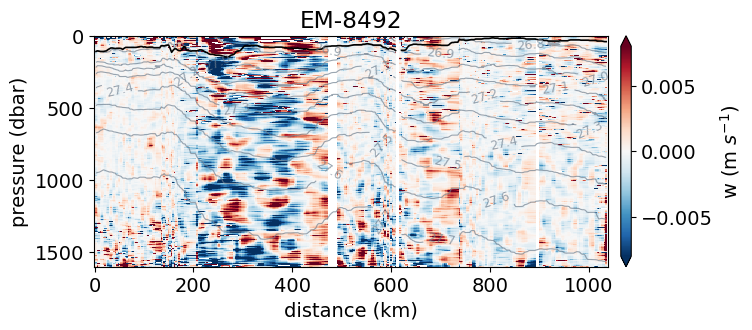

In [26]:
fig, ax = plt.subplots(figsize = (8,3))

pdens = calc.potentialDensity(S_even_dist[floatid].pressure, S_even_dist[floatid], T_even_dist[floatid])
mld_on_p = calc.MLD(pdens, criteria = 0.05, pref = 10)

w_even_dist[floatid].plot(x = 'distance', cmap = 'RdBu_r', vmin = -0.008, vmax = 0.008,
                                            cbar_kwargs={"label": "w (m $s^{-1}$)", 'pad': 0.02, 'extend':'both'})

ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.7)
plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')

# for i in [0]:
#     d1, d2 = locs[8492][i][0], locs[8492][i][1]
#     d = T_even_dist[8492].distance.sel(distance = slice(d1,d2))
#     plt.plot(d, 0*np.arange(0, len(d))+5, c = 'k', linewidth = 7)

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel('pressure (dbar)')
plt.title(f'EM-{floatid}')

In [34]:
# settings.save_figure(fig, my_path, 'w_8492.png', dpi = 600, pad = 0.2)

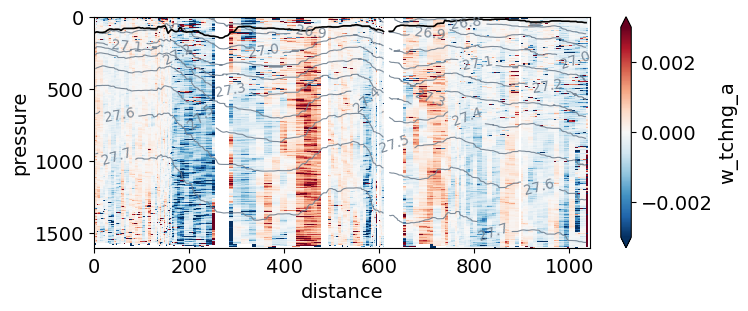

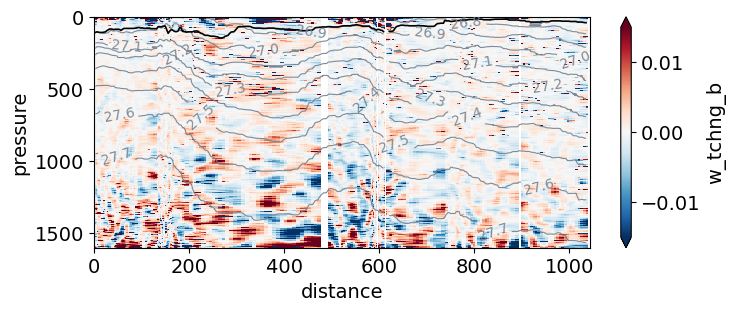

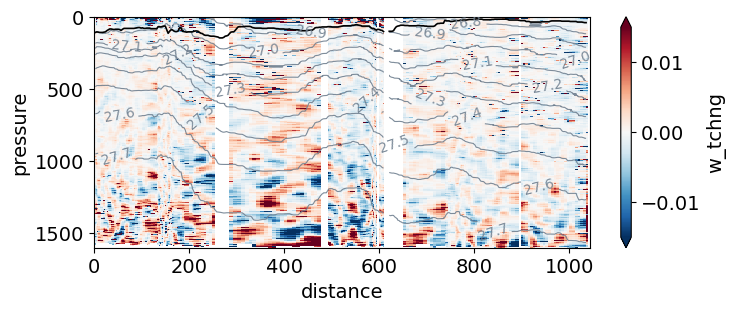

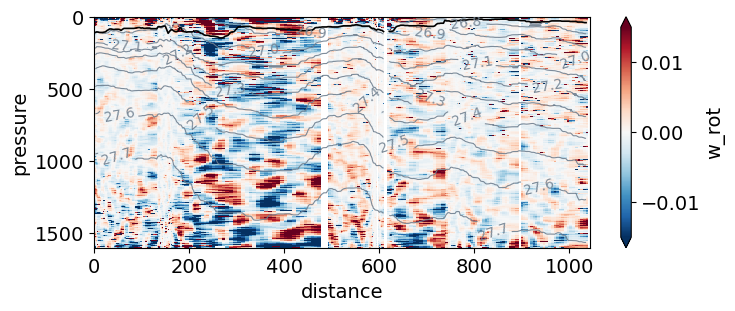

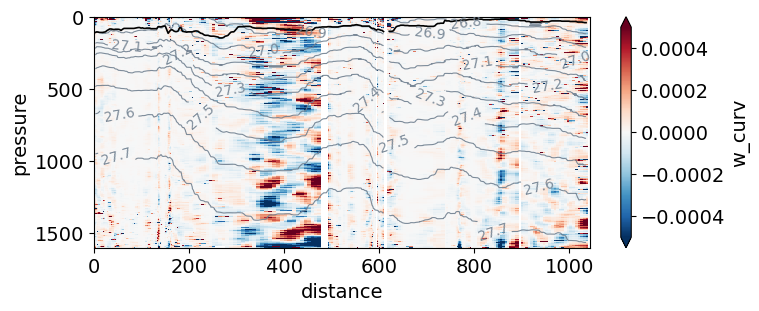

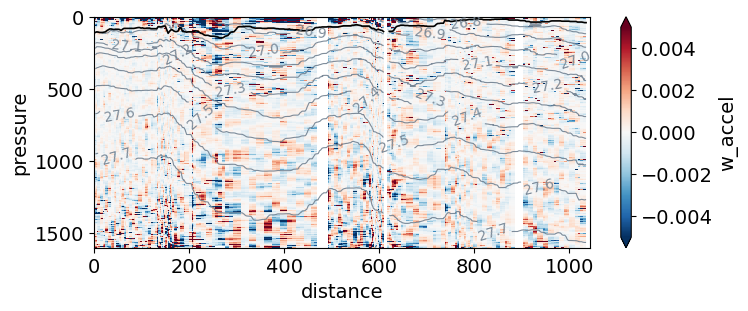

In [27]:
dim = 'distance'

fig, ax = plt.subplots(figsize = (8,3))
vert_vel[floatid].w_tchng_a.plot(x = dim, vmin = -0.003, vmax = 0.003, cmap = 'RdBu_r')
ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.9)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (8,3))
vert_vel[floatid].w_tchng_b.plot(x = dim, vmin = -0.015, vmax = 0.015, cmap = 'RdBu_r')
ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.9)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (8,3))
w_tchng = vert_vel[floatid].w_tchng_a + vert_vel[floatid].w_tchng_b
w_tchng.plot(x = dim, vmin = -0.015, vmax = 0.015, cmap = 'RdBu_r', cbar_kwargs = dict(label = 'w_tchng'))
ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.9)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (8,3))
vert_vel[floatid].w_rot.plot(x = dim, vmin = -0.015, vmax = 0.015, cmap = 'RdBu_r')
ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.9)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (8,3))
vert_vel[floatid].w_curv.plot(x = dim, vmin = -0.0005, vmax = 0.0005, cmap = 'RdBu_r')
ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.9)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (8,3))
vert_vel[floatid].w_accel.plot(x = dim, vmin = -0.005, vmax = 0.005, cmap = 'RdBu_r')
ax.plot(mld_on_p.distance, mld_on_p, c = 'k', linewidth = 1.2)
CS = pdens.plot.contour(x = 'distance', colors = 'slategrey', linewidths = 0.8, levels = levels, alpha = 0.9)
plt.clabel(CS, inline=True, fontsize=10, fmt = '%1.1f')
ax.invert_yaxis()

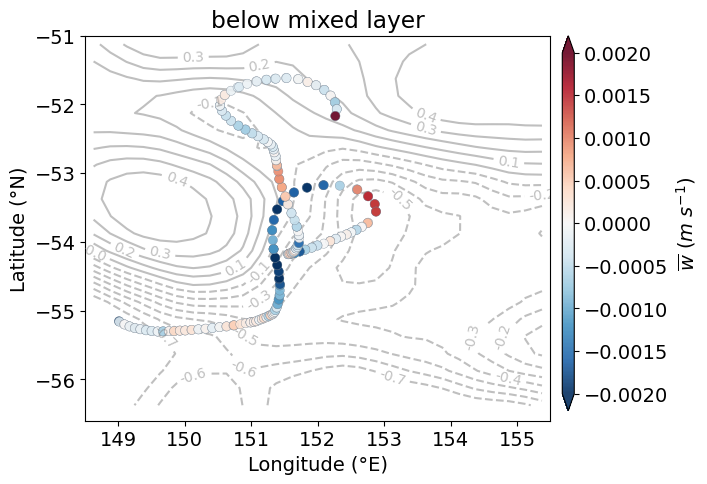

In [28]:
imp.reload(plots)

floatid = 8492

data = w[floatid]                                                     
data1 = data.mean(dim = 'pressure', skipna = True)

data1 = calc.mean_below_ml(data, mld[floatid], zmax = 1600, zdim = 'pressure')

fig, ax = plt.subplots(figsize = (6,5))
im, msl = plots.colTrajectory(ax, data1, float_num, floatid, 
                    alt_cmems, cmap = 'RdBu_r', vmin = -0.002, vmax = 0.002, alpha = 0.9, 
                         s = 45, edgecolors = 'slategrey', linewidth = 0.25)

plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

# plt.title(f'{dens1} - {dens2} ' + '$kg$ $m^{-3}$')
plt.title('below mixed layer')
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, extend = 'both', label = '$\overline{w}$ ($m$ $s^{-1}$)')
